In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc

import itertools
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

#from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Hubble Parameter

In [2]:
z = np.array([[0.07,0.09,0.12,0.17,0.179,0.199,0.200,0.270,0.280,0.352,0.382,0.400,0.4004,0.4247,0.44497,
             0.4783,0.480,0.593,0.680,0.781,0.875,0.880,0.900,1.037,1.300,1.363,1.4307,1.530,1.750,1.965]])
H = np.array([69,69,68.6,83,75,75,72.9,77,88.8,83,83,95,77,67.1,92.8,
             80.9,97,104,92,105,125,90,117,154,168,160,177,140,202,186.5])
u_H = np.array([19.6,12,26.2,8,4,5,29.6,14,36.6,14,13.5,17,10.2,11.1,12.9,
               9,62,13,8,12,17,40,23,20,17,33.6,18,14,40,50.4])

z_BAO = np.array([[0.24,0.35,0.43,0.44,0.57,0.60,0.73,2.30,2.34,2.36]])
H_BAO = np.array([79.69,84.4,86.45,82.6,92.4,87.9,97.3,224,222,226])
u_H_BAO = np.array([2.65,7,3.68,7.8,4.5,6.1,7.0,8,7,8])

In [3]:
X_train = z.T
X_test = z_BAO.T
y_train = np.array([H,u_H]).T
y_test = np.array([H_BAO,u_H_BAO]).T
print(X_train.shape)
print(y_train.shape)

(30, 1)
(30, 2)


In [4]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

X_train[:,0] = X_train[:,0] / np.max(z)
y_train[:,0] = y_train[:,0] / np.max(H)
y_train[:,1] = y_train[:,1] / np.max(u_H)
X_test[:,0] = X_test[:,0] / np.max(z_BAO)
y_test[:,0] = y_test[:,0] / np.max(H_BAO)
y_test[:,1] = y_test[:,1] / np.max(u_H_BAO)

In [5]:
print(X_train.size(), y_train.size())

torch.Size([30, 1]) torch.Size([30, 2])


In [6]:
n_features_i = X_train.shape[1]
n_features_o = y_train.shape[1]
n_samples = X_train.shape[0]

class NeuralNet1(nn.Module):
    def __init__(self, input_size, h1, num_classes):
        super(NeuralNet1,self).__init__()
        self.linear1 = nn.Linear(input_size, h1)
        self.linear2 = nn.Linear(h1,num_classes)
        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        out = self.linear1(x)
        out = self.sig(out)
        out = self.linear2(out)
        
        return out

In [7]:
h1 = 100
model = NeuralNet1(input_size=n_features_i, h1=h1, num_classes=n_features_o)

In [8]:
lr = 1e-1
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(),lr=lr)

In [9]:
num_epochs = 10000
for epoch in range(num_epochs):
    #forward and loss
    y_predicted = model(X_train)
    loss = criterion(y_predicted,y_train)
    #backward
    loss.backward()
    #update
    optimizer.step()
    optimizer.zero_grad()
    
    if (epoch+1) % 1000 == 0:
        print(f'epoch: {epoch+1}, loss = {loss.item():.4f}')

epoch: 1000, loss = 0.0226
epoch: 2000, loss = 0.0225
epoch: 3000, loss = 0.0225
epoch: 4000, loss = 0.0225
epoch: 5000, loss = 0.0224
epoch: 6000, loss = 0.0224
epoch: 7000, loss = 0.0224
epoch: 8000, loss = 0.0223
epoch: 9000, loss = 0.0223
epoch: 10000, loss = 0.0223


In [10]:
predicted = model(X_train).detach().numpy() #requires_grad=false

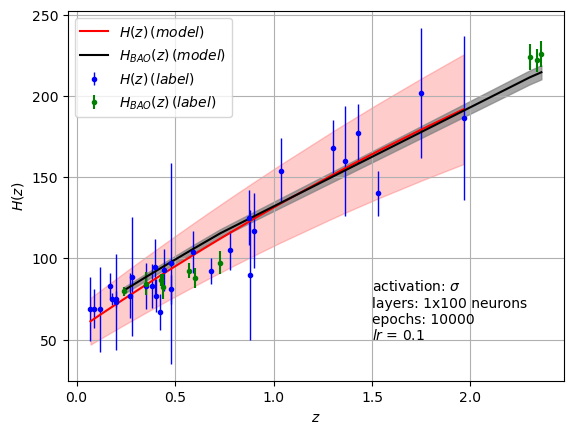

In [13]:

plt.errorbar(z[0].T,H.T,yerr=u_H.T,
                     marker='.',color = 'b', linestyle='',label = '$H(z)\,(label) $',linewidth=1)

plt.plot(z[0].T,predicted[:,0]*np.max(H),'r-',label = '$H(z)\,(model) $')

plt.fill_between(z[0].T, predicted[:,0]*np.max(H) - predicted[:,1]*np.max(u_H), predicted[:,0]*np.max(H) + predicted[:,1]*np.max(u_H),
                 color='red', alpha=0.2)

#plt.errorbar(z[0].T,predicted[:,0]*np.max(H),yerr=predicted[:,1]*np.max(u_H),
#                     marker='.',color = 'r', linestyle='',label = '$H(z)\,(pred) $')

plt.errorbar(z_BAO[0].T,H_BAO.T,yerr=u_H_BAO.T,
                     marker='.',color = 'g', linestyle='',label = '$H_{BAO}(z)\,(label) $')

plt.plot(z_BAO[0].T, model(X_test).detach().numpy()[:,0]*np.max(H_BAO), 'k-',label = '$H_{BAO}(z)\,(model) $')


plt.fill_between(z_BAO[0].T, model(X_test).detach().numpy()[:,0]*np.max(H_BAO) - model(X_test).detach().numpy()[:,1]*np.max(u_H_BAO), model(X_test).detach().numpy()[:,0]*np.max(H_BAO) + model(X_test).detach().numpy()[:,1]*np.max(u_H_BAO),
                 color='gray', alpha=0.7)
plt.legend()
plt.xlabel('$z$')
plt.ylabel('$H(z)$')
plt.text(1.5, 80, r'activation: $\sigma$', fontsize=10)
plt.text(1.5, 70, f'layers: 1x{h1} neurons', fontsize=10)
plt.text(1.5, 60, f'epochs: {num_epochs}', fontsize=10)
plt.text(1.5, 50, f'$lr$ = {lr}', fontsize=10)
plt.grid()
plt.show()

#plt.errorbar(x[:,j],y[:,j],xerr=ux[:,j],yerr=uy[:,j],
                    #marker='.',linestyle='',label=str(T[j])+'\,\,$^\circ\mathrm{C}$')